In [66]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [67]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.7.1+cpu
torchvision version :  0.22.1+cpu
torchinfo version :  1.8.0
numpy version :  2.3.1
matplotlib version :  3.10.3
Python 3.11.4


In [68]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


In [69]:
data_dir = os.path.join("dataset", "data_undersampled", "train")

print("Data directory:", data_dir)

Data directory: dataset\data_undersampled\train


In [70]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [71]:
transform_normalized = transforms.Compose( [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        # Convert images to tensors
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.4326, 0.4953, 0.3120], std = [0.2178, 0.2214, 0.2091]
        )
        
    ]
)
transform_normalized

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4326, 0.4953, 0.312], std=[0.2178, 0.2214, 0.2091])
)

In [72]:
dataset = datasets.ImageFolder(data_dir, transform_normalized)

dataset

Dataset ImageFolder
    Number of datapoints: 5435
    Root location: dataset\data_undersampled\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.4326, 0.4953, 0.312], std=[0.2178, 0.2214, 0.2091])
           )

In [73]:
classes = dataset.classes
classes

['Cassava___bacterial_blight',
 'Cassava___brown_streak_disease',
 'Cassava___green_mottle',
 'Cassava___healthy',
 'Cassava___mosaic_disease']

In [74]:
from training import class_counts

In [75]:
counts = class_counts(dataset)
counts

  0%|          | 0/5435 [00:00<?, ?it/s]

Cassava___bacterial_blight        1087
Cassava___brown_streak_disease    1087
Cassava___green_mottle            1087
Cassava___healthy                 1087
Cassava___mosaic_disease          1087
dtype: int64

In [76]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size)

print(f"Batch shape: {next(iter(dataset_loader))[0].shape}")

Batch shape: torch.Size([32, 3, 224, 224])


In [77]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

In [78]:
test_batch = next(iter(dataset_loader))[0]
batch_shape = test_batch.shape

# Create the model summary
summary(model, input_size=batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [79]:
test_batch = next(iter(dataset_loader))[0]
batch_shape = test_batch.shape

# Create the model summary
summary(model, input_size=batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [80]:
for params in model.parameters():
    params.requires_grad = False

In [81]:
# Move the model to device
model.to(device)

# Move our test_batch to device
test_batch_cuda =  test_batch.to(device)

print("Test batch is running on:", test_batch_cuda.device)

Test batch is running on: cpu


In [82]:
model_test_out = model(test_batch_cuda)
model_test_shape = model_test_out.shape

print("Output shape:", model_test_shape)

Output shape: torch.Size([32, 1000])


In [83]:
list(model.named_modules())[-1]

('fc', Linear(in_features=2048, out_features=1000, bias=True))

In [84]:
in_features = model.fc.in_features
in_features

2048

In [85]:
classifier = torch.nn.Sequential()

In [86]:
classification_layer = torch.nn.Linear(in_features, out_features=256)



# Add the layer to our classifier
classifier.append(classification_layer)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
)

In [87]:
classifier.append(torch.nn.ReLU())
classifier.append(torch.nn.Dropout())

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
)

In [88]:
output_layer = torch.nn.Linear(in_features=256, out_features=5)


# Add the layer to our classifier
classifier.append(output_layer)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

In [89]:
model.fc = classifier

In [90]:
# Create the model summary
summary(model, input_size=batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [91]:
k = 5

kfold_splitter = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=42)

train_nums, val_nums = next(kfold_splitter.split(range(100)))
fold_fraction = len(val_nums) / (len(train_nums) + len(val_nums))
print(f"One fold is {100*fold_fraction:.2f}%")

One fold is 20.00%


In [92]:
from training import predict, train

In [93]:
train?

Signature:
train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    epochs=20,
    device='cpu',
    use_train_accuracy=True,
)
Docstring: <no docstring>
File:      d:\projects\crop disease detections\training.py
Type:      function

In [94]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [95]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

In [96]:
def reset_classifier(model):
    model.fc.get_submodule("0").reset_parameters()
    model.fc.get_submodule("3").reset_parameters()

In [97]:
num_epochs = 6

In [103]:
# you can safely skip this cell and load the model in the next cell

training_records = {}
fold_count = 0

for train_idx, val_idx in kfold_splitter.split(np.arange(len(dataset))):
    fold_count += 1
    print("*****Fold {}*****".format(fold_count))

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(model)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        epochs=num_epochs,
        device=device,
        use_train_accuracy=False,
    )

    # Save training results for graphing
    training_records[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

*****Fold 1*****


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.29
    Validation loss: 1.13
    Validation accuracy: 0.57


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.08
    Validation loss: 1.05
    Validation accuracy: 0.60


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.98
    Validation loss: 1.02
    Validation accuracy: 0.61


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.92
    Validation loss: 1.03
    Validation accuracy: 0.60


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.87
    Validation loss: 1.02
    Validation accuracy: 0.62


Training:   0%|          | 0/136 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.81
    Validation loss: 1.02
    Validation accuracy: 0.62



*****Fold 2*****


Training:   0%|          | 0/136 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

# model = torch.load("pretrained_model.pth", weights_only=False)
# model.to(device)

In [118]:
# import pickle
# with open('training_records.pkl', 'rb') as fp:
#     training_records = pickle.load(fp)

In [104]:
print(type(training_records))
training_records.keys()

<class 'dict'>


dict_keys([1])

In [105]:
print(type(training_records[1]))
training_records[1].keys()

<class 'dict'>


dict_keys(['train_losses', 'val_losses', 'val_accuracies'])

In [106]:
training_records[1]["train_losses"]

[1.2928684684477931,
 1.081567239739419,
 0.9821698472054595,
 0.9154017587374851,
 0.8692197671919211,
 0.8091623954193902]

In [107]:
def plot_all_folds(data, measurement):
    for fold in data.keys():
        plt.plot(data[fold][measurement], label=f"Fold {fold}, {measurement}")
    plt.xlabel("Epochs")
    plt.legend()

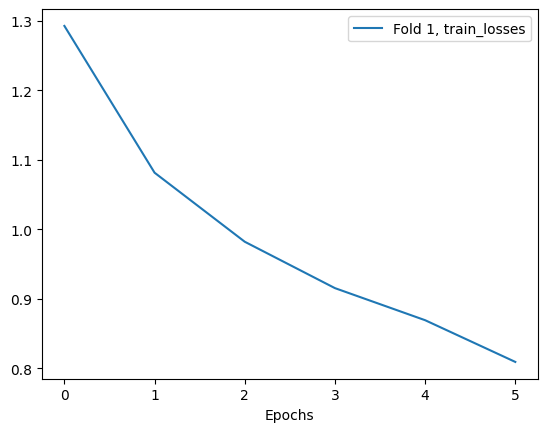

In [108]:
plot_all_folds(training_records, "train_losses")

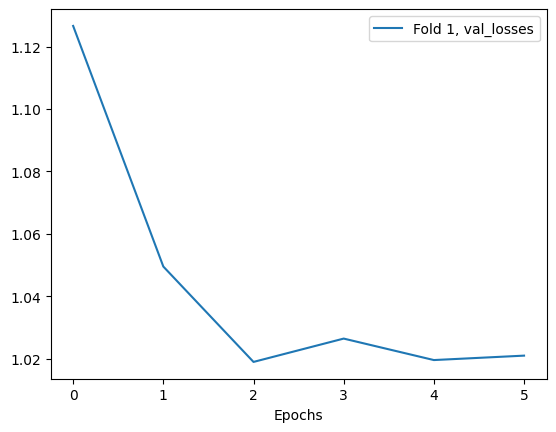

In [109]:
plot_all_folds(training_records, "val_losses")

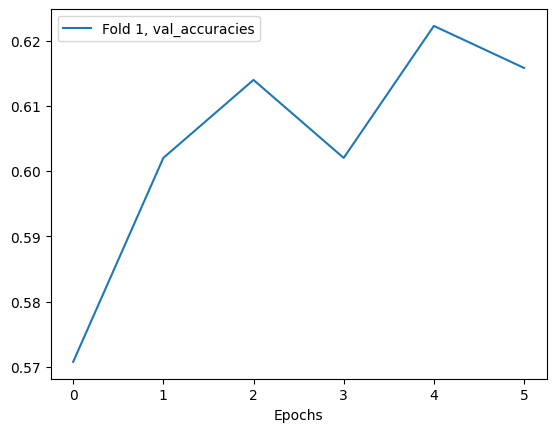

In [110]:
plot_all_folds(training_records, "val_accuracies")

In [111]:
# If you loaded the pre-trained model, make sure you have the correct validation set
_, val_idx = list(kfold_splitter.split(np.arange(len(dataset))))[-1]
val_dataset = torch.utils.data.Subset(dataset, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [112]:
probabilities = predict(model, val_loader, device)
predictions = torch.argmax(probabilities, dim=1)


Predicting:   0%|          | 0/34 [00:00<?, ?it/s]

In [113]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

100%|██████████| 34/34 [00:12<00:00,  2.79it/s]
